<a href="https://colab.research.google.com/github/NarineKhachatryan/NLP/blob/main/nlp1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Large scale text analysis with deep learning

Today we're gonna apply the newly learned tools for the task of predicting job salary.

<img src="https://storage.googleapis.com/kaggle-competitions/kaggle/3342/media/salary%20prediction%20engine%20v2.png" width=400px>

_Special thanks to [Oleg Vasilev](https://github.com/Omrigan/) for the core assignment idea._

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### About the challenge
For starters, let's download and unpack the data from [here](https://www.dropbox.com/s/5msc5ix7ndyba10/Train_rev1.csv.tar.gz?dl=0). 

You can also get it from [yadisk url](https://yadi.sk/d/vVEOWPFY3NruT7) the competition [page](https://www.kaggle.com/c/job-salary-prediction/data) (pick `Train_rev1.*`).

In [ ]:
!curl -L https://www.dropbox.com/s/5msc5ix7ndyba10/Train_rev1.csv.tar.gz?dl=1 -o Train_rev1.csv.tar.gz
!tar -xvzf ./Train_rev1.csv.tar.gz
data = pd.read_csv("./Train_rev1.csv", index_col=None)
data.shape

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   145    0   145    0     0    354      0 --:--:-- --:--:-- --:--:--   355
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  119M  100  119M    0     0  8078k      0  0:00:15  0:00:15 --:--:-- 9223k
Train_rev1.csv


(244768, 12)

In [ ]:
data = pd.read_csv("./Train_rev1.csv", index_col=None)

In [ ]:
data.head()

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName
0,12612628,Engineering Systems Analyst,Engineering Systems Analyst Dorking Surrey Sal...,"Dorking, Surrey, Surrey",Dorking,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk
1,12612830,Stress Engineer Glasgow,Stress Engineer Glasgow Salary **** to **** We...,"Glasgow, Scotland, Scotland",Glasgow,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 35000/annum 25-35K,30000,cv-library.co.uk
2,12612844,Modelling and simulation analyst,Mathematical Modeller / Simulation Analyst / O...,"Hampshire, South East, South East",Hampshire,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 40000/annum 20-40K,30000,cv-library.co.uk
3,12613049,Engineering Systems Analyst / Mathematical Mod...,Engineering Systems Analyst / Mathematical Mod...,"Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 30000/annum 25K-30K negotiable,27500,cv-library.co.uk
4,12613647,"Pioneer, Miser Engineering Systems Analyst","Pioneer, Miser Engineering Systems Analyst Do...","Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk


In [ ]:
data.describe()

,Id,SalaryNormalized
count,2.447680e+05,244768.000000
mean,6.970142e+07,34122.577576
std,3.129813e+06,17640.543124
min,1.261263e+07,5000.000000
25%,6.869550e+07,21500.000000
50%,6.993700e+07,30000.000000
75%,7.162606e+07,42500.000000
max,7.270524e+07,200000.000000


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244768 entries, 0 to 244767
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   Id                  244768 non-null  int64 
 1   Title               244767 non-null  object
 2   FullDescription     244768 non-null  object
 3   LocationRaw         244768 non-null  object
 4   LocationNormalized  244768 non-null  object
 5   ContractType        65442 non-null   object
 6   ContractTime        180863 non-null  object
 7   Company             212338 non-null  object
 8   Category            244768 non-null  object
 9   SalaryRaw           244768 non-null  object
 10  SalaryNormalized    244768 non-null  int64 
 11  SourceName          244767 non-null  object
dtypes: int64(2), object(10)
memory usage: 22.4+ MB


In [ ]:

data.isna().sum()

Id                         0
Title                      1
FullDescription            0
LocationRaw                0
LocationNormalized         0
ContractType          179326
ContractTime           63905
Company                32430
Category                   0
SalaryRaw                  0
SalaryNormalized           0
SourceName                 1
dtype: int64

One problem with salary prediction is that it's oddly distributed: there are many people who are paid standard salaries and a few that get tons o money. The distribution is fat-tailed on the right side, which is inconvenient for MSE minimization.

There are several techniques to combat this: using a different loss function, predicting log-target instead of raw target or even replacing targets with their percentiles among all salaries in the training set. We gonna use logarithm for now.

_You can read more [in the official description](https://www.kaggle.com/c/job-salary-prediction#description)._

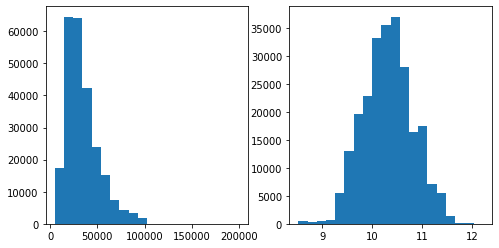

In [ ]:
data['Log1pSalary'] = np.log1p(data['SalaryNormalized']).astype('float32')

plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.hist(data["SalaryNormalized"], bins=20);

plt.subplot(1, 2, 2)
plt.hist(data['Log1pSalary'], bins=20);

Our task is to predict one number, __Log1pSalary__.

To do so, our model can access a number of features:
* Free text: __`Title`__ and  __`FullDescription`__
* Categorical: __`Category`__, __`Company`__, __`LocationNormalized`__, __`ContractType`__, and __`ContractTime`__.

In [ ]:
text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
target_column = "Log1pSalary"

data[categorical_columns] = data[categorical_columns].fillna('NaN') # cast missing values to string "NaN"

data.sample(3)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
78656,69015671,Mortgage Advisors,A handful of these quality roles are currently...,"Romford, Essex",Romford,NaN,permanent,Bee You Ltd,Property Jobs,"18000 - 20000/annum basic OTE 30,000 plus",19000,cv-library.co.uk,9.852247
66841,68714667,Global Data Analytics Manager,This role will be pivotal in driving forward t...,"Slough, Berkshire Berkshire South East",Slough,NaN,permanent,Michael Page Marketing,"PR, Advertising & Marketing Jobs",38000 to 45000 per annum,41500,totaljobs.com,10.633472
31651,68085694,Accounts Administrator **** month Fixed Term ...,David Salisbury is one of the UK’s leading man...,"Highbridge, Somerset Somerset South West",Highbridge,NaN,contract,David Salisbury Joinery Ltd,Accounting & Finance Jobs,"From 15,000 to 17,000 per annum",16000,totaljobs.com,9.680407


In [ ]:
data.isna().sum()

Id                    0
Title                 1
FullDescription       0
LocationRaw           0
LocationNormalized    0
ContractType          0
ContractTime          0
Company               0
Category              0
SalaryRaw             0
SalaryNormalized      0
SourceName            1
Log1pSalary           0
dtype: int64

### Preprocessing text data

Just like last week, applying NLP to a problem begins from tokenization: splitting raw text into sequences of tokens (words, punctuation, etc).

__Your task__ is to lowercase and tokenize all texts under `Title` and `FullDescription` columns. Store the tokenized data as a __space-separated__ string of tokens for performance reasons.

It's okay to use nltk tokenizers. Assertions were designed for WordPunctTokenizer, slight deviations are okay.

In [ ]:
print("Raw text:")
print(data["FullDescription"][2::100000])

Raw text:
2         Mathematical Modeller / Simulation Analyst / O...
100002    A successful and high achieving specialist sch...
200002    Web Designer  HTML, CSS, JavaScript, Photoshop...
Name: FullDescription, dtype: object


In [ ]:
#lowercase
data['FullDescription'] = data['FullDescription'].str.lower()
data['Title'] = data['Title'].str.lower()

In [ ]:
#tokenize
import nltk
from nltk.tokenize import RegexpTokenizer
tokenizer = nltk.tokenize.WordPunctTokenizer()
#data['FullDescription']=data['FullDescription'].apply(str)
data['FullDescription']=data['FullDescription'].apply(tokenizer.tokenize)


In [ ]:
data['FullDescription']

0         [engineering, systems, analyst, dorking, surre...
1         [stress, engineer, glasgow, salary, ****, to, ...
2         [mathematical, modeller, /, simulation, analys...
3         [engineering, systems, analyst, /, mathematica...
4         [pioneer, ,, miser, engineering, systems, anal...
                                ...                        
244763    [position, :, qualified, teacher, subject, /, ...
244764    [position, :, qualified, teacher, or, nqt, sub...
244765    [position, :, qualified, teacher, subject, /, ...
244766    [position, :, qualified, teacher, subject, /, ...
244767    [this, entrepreneurial, and, growing, private,...
Name: FullDescription, Length: 244768, dtype: object

In [ ]:
#tokenize
data['Title']=data['Title'].apply(str)
data['Title']=data['Title'].apply(tokenizer.tokenize)


In [ ]:
data['Title'][0]

['engineering', 'systems', 'analyst']

Now we can assume that our text is a space-separated list of tokens:

In [ ]:
print("Tokenized:")
print(data["FullDescription"][2::100000])
assert data["FullDescription"][2][:50] == 'mathematical modeller / simulation analyst / opera'
assert data["Title"][54321] == 'international digital account manager ( german )'

Tokenized:
2         [mathematical, modeller, /, simulation, analys...
100002    [a, successful, and, high, achieving, speciali...
200002    [web, designer, html, ,, css, ,, javascript, ,...
Name: FullDescription, dtype: object


AssertionError: ignored

Not all words are equally useful. Some of them are typos or rare words that are only present a few times. 

Let's count how many times is each word present in the data so that we can build a "white list" of known words.

In [ ]:
data.head()

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
0,12612628,"[engineering, systems, analyst]","[engineering, systems, analyst, dorking, surre...","Dorking, Surrey, Surrey",Dorking,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk,10.126671
1,12612830,"[stress, engineer, glasgow]","[stress, engineer, glasgow, salary, ****, to, ...","Glasgow, Scotland, Scotland",Glasgow,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 35000/annum 25-35K,30000,cv-library.co.uk,10.308986
2,12612844,"[modelling, and, simulation, analyst]","[mathematical, modeller, /, simulation, analys...","Hampshire, South East, South East",Hampshire,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 40000/annum 20-40K,30000,cv-library.co.uk,10.308986
3,12613049,"[engineering, systems, analyst, /, mathematica...","[engineering, systems, analyst, /, mathematica...","Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 30000/annum 25K-30K negotiable,27500,cv-library.co.uk,10.221977
4,12613647,"[pioneer, ,, miser, engineering, systems, anal...","[pioneer, ,, miser, engineering, systems, anal...","Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk,10.126671


In [ ]:
# Count how many times does each token occur in both "Title" and "FullDescription" in total
# build a dictionary { token -> it's count }
from collections import Counter
flatlist_title=[item for elem in list(data["Title"]) for item in elem ]
token_counts_title = Counter(flatlist_title)

flatlist_title_des=[item for elem in list(data["FullDescription"]) for item in elem ]
token_counts_des = Counter(flatlist_title_des)

token_counts_list=flatlist_title+flatlist_title_des

token_counts=Counter(token_counts_list)

# hint: you may or may not want to use collections.Counter

In [ ]:
token_counts

Counter({'engineering': 68563,
         'systems': 77071,
         'analyst': 34427,
         'stress': 1855,
         'engineer': 94623,
         'glasgow': 3333,
         'modelling': 6534,
         'and': 2657388,
         'simulation': 1314,
         '/': 554003,
         'mathematical': 1033,
         'modeller': 551,
         'pioneer': 381,
         ',': 2318606,
         'miser': 8,
         'water': 8259,
         'industry': 59732,
         'senior': 87513,
         'subsea': 1237,
         'pipeline': 3009,
         'integrity': 4456,
         'recruitment': 123310,
         'consultant': 44396,
         'industrial': 9498,
         'commercial': 56187,
         'driv': 9,
         'construction': 16679,
         'technical': 91480,
         'trades': 1190,
         'labour': 2069,
         'cables': 342,
         'trainee': 7805,
         'mortgage': 3564,
         'advisor': 16299,
         'east': 20244,
         'midlands': 11141,
         'project': 102963,
         'ph

In [ ]:
print("Total unique tokens :", len(token_counts))
print('\n'.join(map(str, token_counts.most_common(n=5))))
print('...')
print('\n'.join(map(str, token_counts.most_common()[-3:])))

assert token_counts.most_common(1)[0][1] in  range(2600000, 2700000)
assert len(token_counts) in range(200000, 210000)
print('Correct!')

Total unique tokens : 202704
('and', 2657388)
('.', 2523216)
(',', 2318606)
('the', 2080994)
('to', 2019884)
...
('stephanietraveltraderecruitmnt', 1)
('ruabon', 1)
('lowehays', 1)
Correct!


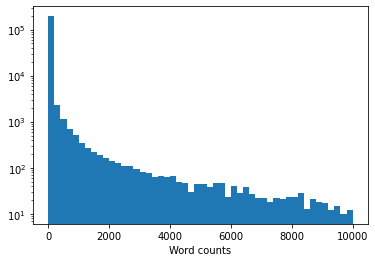

In [ ]:
# Let's see how many words are there for each count
plt.hist(list(token_counts.values()), range=[0, 10**4], bins=50, log=True)
plt.xlabel("Word counts");

Now filter tokens a list of all tokens that occur at least 10 times.

In [ ]:
token_counts

Counter({'engineering': 68563,
         'systems': 77071,
         'analyst': 34427,
         'stress': 1855,
         'engineer': 94623,
         'glasgow': 3333,
         'modelling': 6534,
         'and': 2657388,
         'simulation': 1314,
         '/': 554003,
         'mathematical': 1033,
         'modeller': 551,
         'pioneer': 381,
         ',': 2318606,
         'miser': 8,
         'water': 8259,
         'industry': 59732,
         'senior': 87513,
         'subsea': 1237,
         'pipeline': 3009,
         'integrity': 4456,
         'recruitment': 123310,
         'consultant': 44396,
         'industrial': 9498,
         'commercial': 56187,
         'driv': 9,
         'construction': 16679,
         'technical': 91480,
         'trades': 1190,
         'labour': 2069,
         'cables': 342,
         'trainee': 7805,
         'mortgage': 3564,
         'advisor': 16299,
         'east': 20244,
         'midlands': 11141,
         'project': 102963,
         'ph

Now filter tokens a list of all tokens that occur at least 10 times.

In [ ]:
min_count = 10

# tokens from token_counts keys that had at least min_count occurrences throughout the dataset
tokens={}
for key,value in token_counts.items():
  if (value > min_count):
    tokens[key]=value


In [ ]:
tokens

{'engineering': 68563,
 'systems': 77071,
 'analyst': 34427,
 'stress': 1855,
 'engineer': 94623,
 'glasgow': 3333,
 'modelling': 6534,
 'and': 2657388,
 'simulation': 1314,
 '/': 554003,
 'mathematical': 1033,
 'modeller': 551,
 'pioneer': 381,
 ',': 2318606,
 'water': 8259,
 'industry': 59732,
 'senior': 87513,
 'subsea': 1237,
 'pipeline': 3009,
 'integrity': 4456,
 'recruitment': 123310,
 'consultant': 44396,
 'industrial': 9498,
 'commercial': 56187,
 'construction': 16679,
 'technical': 91480,
 'trades': 1190,
 'labour': 2069,
 'cables': 342,
 'trainee': 7805,
 'mortgage': 3564,
 'advisor': 16299,
 'east': 20244,
 'midlands': 11141,
 'project': 102963,
 'pharmaceutical': 5529,
 'principal': 6936,
 'composite': 552,
 'fatigue': 212,
 'damage': 576,
 'tolerance': 412,
 'chef': 31881,
 'de': 11144,
 'partie': 9314,
 'award': 10697,
 'winning': 11728,
 'restaurant': 18943,
 'excellent': 144946,
 'tips': 1768,
 'quality': 81264,
 'controls': 8120,
 'dining': 4136,
 'live': 23550,
 'in

In [ ]:
# Add a special tokens for unknown and empty words
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + sorted(tokens)
print("Vocabulary size:", len(tokens))

assert type(tokens) == list
assert len(tokens) in range(32000, 35000)
assert 'me' in tokens
assert UNK in tokens
print("Correct!")

Vocabulary size: 32456
Correct!


Build an inverse token index: a dictionary from token(string) to it's index in `tokens` (int)

In [ ]:
token_to_id = dict(zip(tokens,range(len(tokens))))


In [ ]:
assert isinstance(token_to_id, dict)
assert len(token_to_id) == len(tokens)
for tok in tokens:
    assert tokens[token_to_id[tok]] == tok

print("Correct!")

Correct!


And finally, let's use the vocabulary you've built to map text lines into neural network-digestible matrices.

In [ ]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))
        
    max_len = min(max(map(len, sequences)), max_len or float('inf'))
    
    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [ ]:
str((data["Title"][::100000]).values)

"[list(['engineering', 'systems', 'analyst']) list(['hr', 'assistant'])\n list(['senior', 'ec', '&', 'i', 'engineer'])]"

In [ ]:
print("Lines:")
#print('\n'.join(str(data["Title"][::100000].values)), end='\n\n')
print("Matrix:")
print(as_matrix(data["Title"][::100000]))

Lines:
Matrix:
[[10273 28655  2055     1     1]
 [14296  2700     1     1     1]
 [26272  9698    14 14484 10270]]


Now let's  encode the categirical data we have.

As usual, we shall use one-hot encoding for simplicity. Kudos if you implement more advanced encodings: tf-idf, pseudo-time-series, etc.

In [ ]:
from sklearn.feature_extraction import DictVectorizer

# we only consider top-1k most frequent companies to minimize memory usage
top_companies, top_counts = zip(*Counter(data['Company']).most_common(1000))
recognized_companies = set(top_companies)
data["Company"] = data["Company"].apply(lambda comp: comp if comp in recognized_companies else "Other")

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))

DictVectorizer(dtype=<class 'numpy.float32'>, separator='=', sort=True,
               sparse=False)

The deep learning part
Once we've learned to tokenize the data, let's design a machine learning experiment.

As before, we won't focus too much on validation, opting for a simple train-test split.

To be completely rigorous, we've comitted a small crime here: we used the whole data for tokenization and vocabulary building. A more strict way would be to do that part on training set only. You may want to do that and measure the magnitude of changes.

In [ ]:
from sklearn.model_selection import train_test_split

data_train, data_val = train_test_split(data, test_size=0.2, random_state=42)
data_train.index = range(len(data_train))
data_val.index = range(len(data_val))

print("Train size = ", len(data_train))

Train size =  195814


In [ ]:
def make_batch(data, max_len=None, word_dropout=0):
    """
    Creates a keras-friendly dict from the batch data.
    :param word_dropout: replaces token index with UNK_IX with this probability
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    batch = {}
    batch["Title"] = as_matrix(data["Title"].values, max_len)
    batch["FullDescription"] = as_matrix(data["FullDescription"].values, max_len)
    batch['Categorical'] = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))
    
    if word_dropout != 0:
        batch["FullDescription"] = apply_word_dropout(batch["FullDescription"], 1. - word_dropout)
    
    if target_column in data.columns:
        batch[target_column] = data[target_column].values
    
    return batch

def apply_word_dropout(matrix, keep_prop, replace_with=UNK_IX, pad_ix=PAD_IX,):
    dropout_mask = np.random.choice(2, np.shape(matrix), p=[keep_prop, 1 - keep_prop])
    dropout_mask &= matrix != pad_ix
    return np.choose(dropout_mask, [matrix, np.full_like(matrix, replace_with)])

In [ ]:
make_batch(data_train[:3], max_len=10)

{'Categorical': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 'FullDescription': array([[26272, 28401, 31999, 31307,   909, 26272, 28401, 31999, 15662,
         31307],
        [27772,   187, 18227, 19056, 14801, 22008,  3848, 24230,   836,
            77],
        [29212, 20872, 19591,  6092, 15662,  7773, 26125,   909, 28895,
         16876]], dtype=int32),
 'Log1pSalary': array([ 9.71154 , 10.463132, 10.71444 ], dtype=float32),
 'Title': array([[26272, 28401, 31999,     1,     1,     1,     1],
        [27772,   187, 18227, 19056, 14801, 22008,  3848],
        [10082, 28895, 16876,    31,  8281, 27695,    61]], dtype=int32)}

#### Architecture

Our basic model consists of three branches:
* Title encoder
* Description encoder
* Categorical features encoder

We will then feed all 3 branches into one common network that predicts salary.

<img src="https://github.com/yandexdataschool/nlp_course/raw/master/resources/w2_conv_arch.png" width=600px>

This clearly doesn't fit into keras' Sequential interface. To build such a network, one will have to use Keras Functional API.

In [51]:
len(tokens)

32456

In [52]:
len(categorical_vectorizer.vocabulary_)

3768

In [55]:
import keras
import keras.layers as L
from keras.layers.merge import concatenate

In [56]:
def build_model(n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=64):
    """ Build a model that maps three data sources to a single linear output: predicted log1p(salary) """
    
    l_title = L.Input(shape=[n_tokens], name="Title")
    l_descr = L.Input(shape=[n_tokens], name="FullDescription")
    l_categ = L.Input(shape=[n_cat_features], name="Categorical")
    
    
    # the first branch operates on the first input
    x = L.Dense(64, activation="relu")(l_title)
    x = L.Dense(32, activation="relu")(x)
    x = L.Dense(4, activation="relu")(x)
    x = keras.models.Model(inputs=l_title, outputs=x)

    # the second branch opreates on the second input
    y = L.Dense(64, activation="relu")(l_descr)
    y = L.Dense(32, activation="relu")(y)
    y = L.Dense(4, activation="relu")(y)
    y = keras.models.Model(inputs=l_descr, outputs=y)

    # the third branch opreates on the second input
    z = L.Dense(64, activation="relu")(l_categ)
    z = L.Dense(32, activation="relu")(y)
    z = L.Dense(4, activation="relu")(y)
    z = keras.models.Model(inputs=l_categ, outputs=z)

    # combine the output of the two branches
    combined =concatenate([x.output, y.output.z.output])
    # apply a FC layer and then a regression prediction on the
    # combined outputs
    output_layer = L.Dense(2, activation="relu")(combined)
    output_layer = L.Dense(1, activation="linear")(output_layer)
    # our model will accept the inputs of the three branches and
    # then output a single value
    
    
    model = keras.models.Model(inputs=[l_title, l_descr, l_categ], outputs=[output_layer])
    model.compile('adam', 'mean_squared_error', metrics=['mean_absolute_error'])
    return model

In [57]:
model = build_model()
model.summary()

dummy_pred = model.predict(make_batch(data_train[:100]))
dummy_loss = model.train_on_batch(make_batch(data_train[:100]), data_train['Log1pSalary'][:100])[0]
assert dummy_pred.shape == (100, 1)
assert len(np.unique(dummy_pred)) > 20, "model returns suspiciously few unique outputs. Check your initialization"
assert np.ndim(dummy_loss) == 0 and 0. <= dummy_loss <= 250., "make sure you minimize MSE"

TypeError: ignored

#### Training and evaluation

As usual, we gonna feed our monster with random minibatches of data. 

As we train, we want to monitor not only loss function, which is computed in log-space, but also the actual error measured in dollars.

In [45]:
def iterate_minibatches(data, batch_size=256, shuffle=True, cycle=False, **kwargs):
    """ iterates minibatches of data in random order """
    while True:
        indices = np.arange(len(data))
        if shuffle:
            indices = np.random.permutation(indices)

        for start in range(0, len(indices), batch_size):
            batch = make_batch(data.iloc[indices[start : start + batch_size]], **kwargs)
            target = batch.pop(target_column)
            yield batch, target
        
        if not cycle: break

### Model training

We can now fit our model the usual minibatch way. The interesting part is that we train on an infinite stream of minibatches, produced by `iterate_minibatches` function.

In [46]:
batch_size = 256
epochs = 10            # definitely too small
steps_per_epoch = 100  # for full pass over data: (len(data_train) - 1) // batch_size + 1

model = build_model()

model.fit_generator(iterate_minibatches(data_train, batch_size, cycle=True, word_dropout=0.05), 
                    epochs=epochs, steps_per_epoch=steps_per_epoch,
                    
                    validation_data=iterate_minibatches(data_val, batch_size, cycle=True),
                    validation_steps=data_val.shape[0] // batch_size
                   )

TypeError: ignored

In [47]:
def print_metrics(model, data, batch_size=batch_size, name="", **kw):
    squared_error = abs_error = num_samples = 0.0
    for batch_x, batch_y in iterate_minibatches(data, batch_size=batch_size, shuffle=False, **kw):
        batch_pred = model.predict(batch_x)[:, 0]
        squared_error += np.sum(np.square(batch_pred - batch_y))
        abs_error += np.sum(np.abs(batch_pred - batch_y))
        num_samples += len(batch_y)
    print("%s results:" % (name or ""))
    print("Mean square error: %.5f" % (squared_error / num_samples))
    print("Mean absolute error: %.5f" % (abs_error / num_samples))
    return squared_error, abs_error
    
print_metrics(model, data_train, name='Train')
print_metrics(model, data_val, name='Val');

NameError: ignored